In [23]:
# Import required libraries
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns

# Import necessary modules
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error


In [24]:
#import data
df= pd.read_excel("/Users/sophi/Downloads/output.xlsx")
# print(df.shape)
# df.describe().transpose()

In [25]:
# creates an object of the target variable NEE and an object of independent variables
NEE_column = ['NEE'] 
predictors_columns = list(set(list(df.columns))-set(NEE_column))

# unscaled (standard scaler)
X_unscaled = df[predictors_columns].values
y_unscaled = df[NEE_column].values

# normalizing (Edwin)
df[predictors_columns] = df[predictors_columns]/df[predictors_columns].max()
df.describe().transpose()

# set x and y (Edwin)
X = df[predictors_columns].values
y = df[NEE_column].values

In [26]:
# split data (Edwin)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=40)

# split data (standard scaler)
X_train2, X_test2, y_train2, y_test2 = train_test_split(X_unscaled, y_unscaled, test_size=0.30, random_state=40)



In [27]:
# normalizing (standard scaler)
scaler = StandardScaler()
train_features = scaler.fit_transform(X_train2)
test_features = scaler.transform(X_test2)

In [37]:
# training model and making predictions
# create model (Edwin)
mlp = MLPRegressor(activation='relu', hidden_layer_sizes=(50,50,50), alpha=0.001,random_state=21, early_stopping=False)
mlp.fit(X_train, y_train)

# create model (standard scaler)
mlp2 = MLPRegressor(activation='relu', hidden_layer_sizes=(50,50,50), alpha=0.001,random_state=21, early_stopping=False)
mlp2.fit(train_features, y_train2)

# predict_test = mlp.predict(X_test)

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1623: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1623: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/skl

MLPRegressor(alpha=0.001, hidden_layer_sizes=(50, 50, 50), random_state=21)

In [38]:
# Calculate accuracy and error metrics
# test model (Edwin)
test_set_rsquared = mlp.score(X_test, y_test)
print('Accuracy:',test_set_rsquared)

# test model (standard scaler)
test_set_rsquared2 = mlp2.score(test_features, y_test2)
print('Accuracy:',test_set_rsquared2)

# test_set_rsquared = mlp.score(X_test, y_test)
# test_set_rmse = np.sqrt(mean_squared_error(y_test, predict_test))

# print('R_squared value: ', test_set_rsquared)
# print('RMSE: ', test_set_rmse)

Accuracy: 0.5312946707710574
Accuracy: 0.5144893035379858


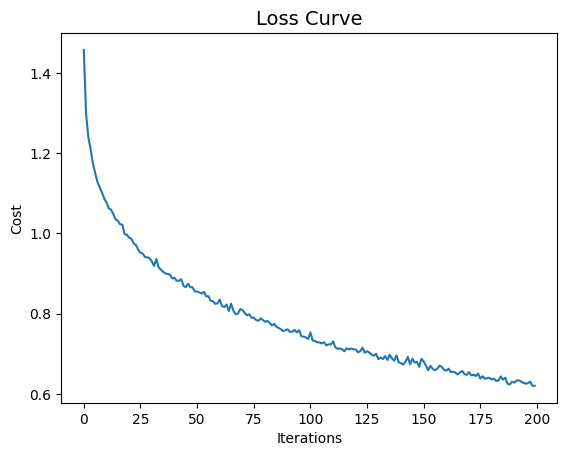

In [7]:
plt.plot(mlp.loss_curve_)
plt.title("Loss Curve", fontsize=14)
plt.xlabel('Iterations')
plt.ylabel('Cost')
plt.show()

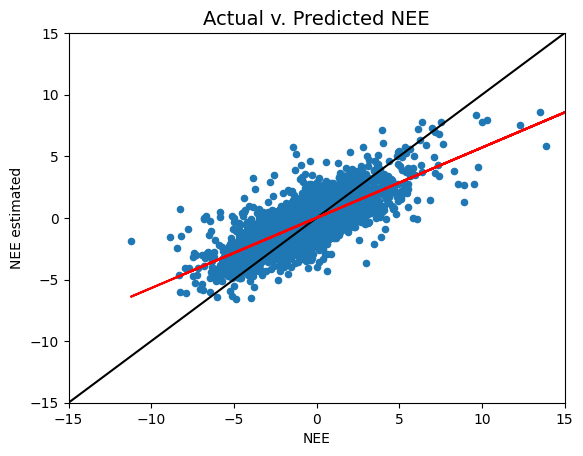

In [8]:
flattened_y_test = y_test.ravel().tolist()

plt.scatter(y_test, predict_test, s=20)
plt.plot([-15,15], [-15,15], 'black')
coefficients = np.polyfit(flattened_y_test, predict_test, 1)
plt.plot(y_test, np.polyval(coefficients, y_test), color='red', label='Line of Best Fit')

plt.xlim([-15, 15])
plt.ylim([-15, 15])
plt.title("Actual v. Predicted NEE", fontsize=14)
plt.xlabel('NEE')
plt.ylabel('NEE estimated')
plt.show()

In [9]:
### Feature Importance and Partial Dependence
#
dff = df.drop('NEE', axis=1).median()
predict_variation = pd.DataFrame(columns = dff.index)
arg = pd.DataFrame(columns = dff.index)
count = 0

for index in dff.index:
    # create variables to store min and max value for "SW_IN"
    minimum, maximum = df[index].min(), df[index].max()
    
    # create an evenly spaced array of 100 value between min and max
    arr = np.arange(minimum, maximum, (maximum - minimum)/100)

    # now create lst of all inputs
    lst = []

    # loop over each variation generated in array
    for variation in arr:
        all_vals = list(df.drop('NEE', axis=1).median().values)
    
        # replace nth variable column with variation
        all_vals[count] = variation
    
        # append variation with ceteris paribus to list of inputs
        lst.append(all_vals)
    
    # transform lst into numpy array to fit model format for evaluation
    lst = np.array(lst)

    arg[index] = arr
    predict_variation[index] = mlp.predict(lst)

    count = count + 1

In [10]:
impact_dct = {}
keys = dff.index
for index in dff.index:
    impact = abs(predict_variation[index].max() - predict_variation[index].min())
    impact_dct[index] = impact


Text(0.5, 1.0, 'ANN Feature Importance on NEE')

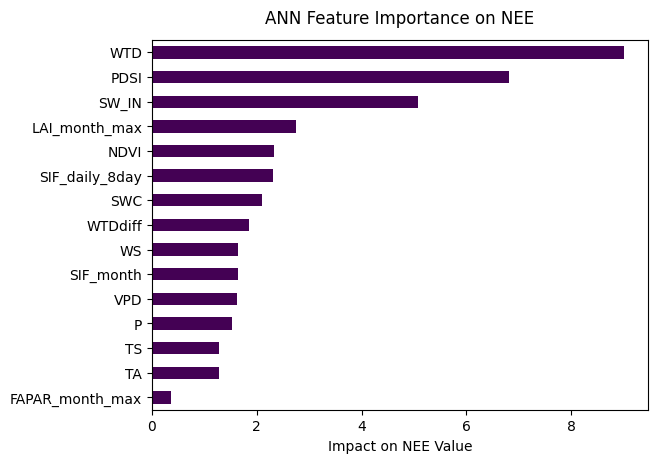

In [11]:
pd.DataFrame.from_dict(impact_dct, orient='index', columns=['Impact']).sort_values(by="Impact").plot(kind='barh', colormap='viridis')
plt.xlabel("Impact on NEE Value")
plt.legend().remove()
plt.title("ANN Feature Importance on NEE", pad=12)

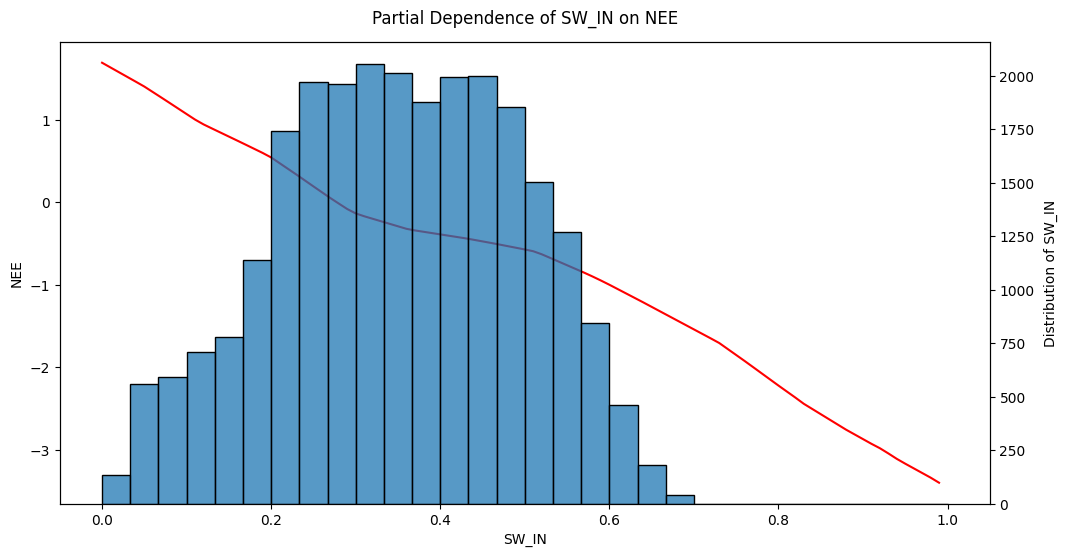

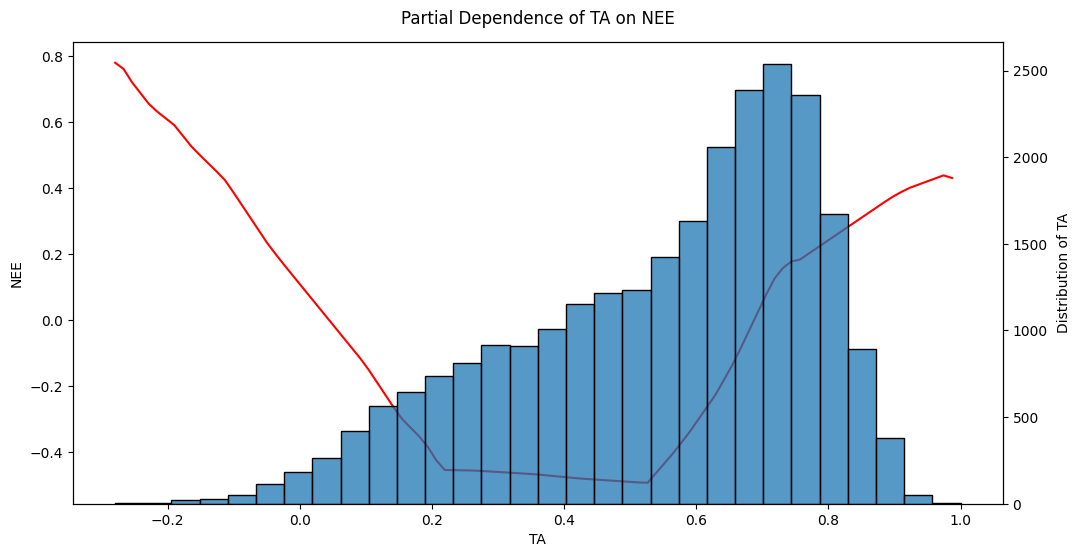

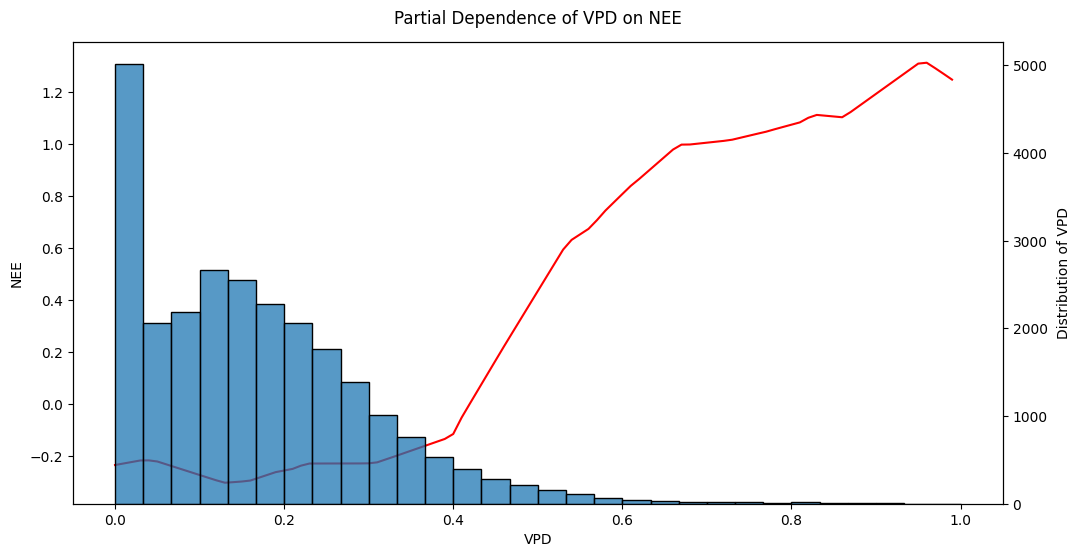

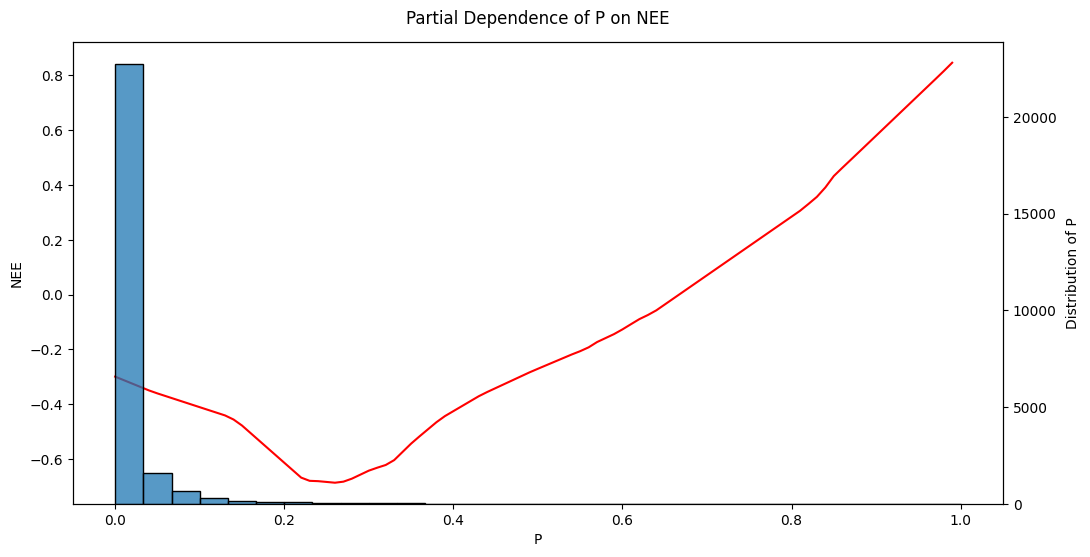

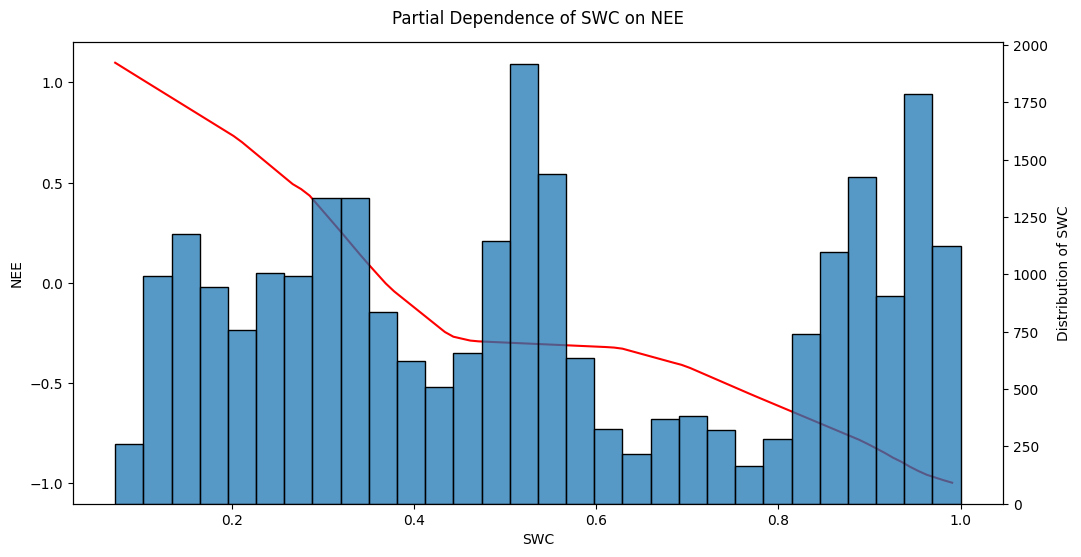

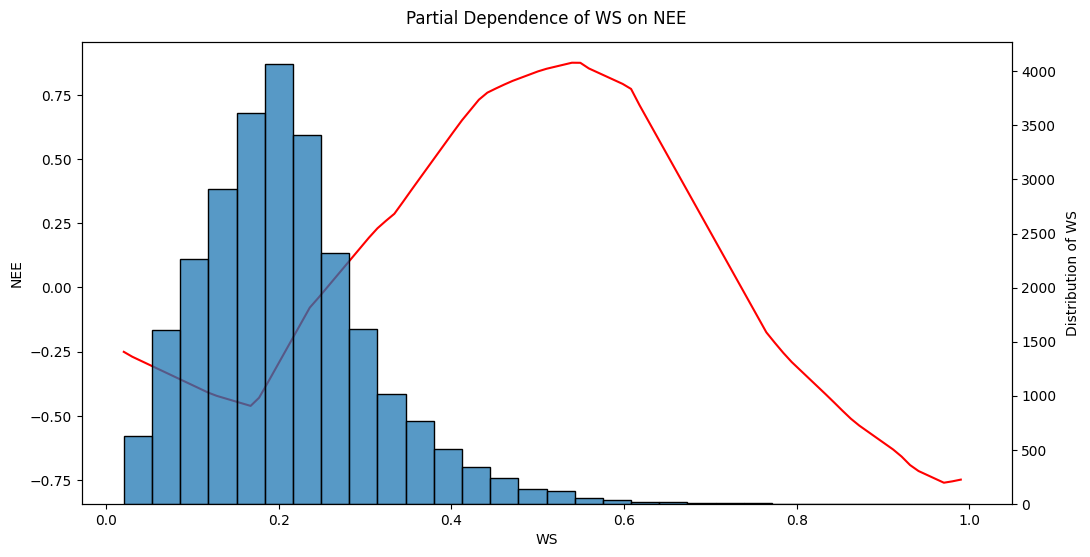

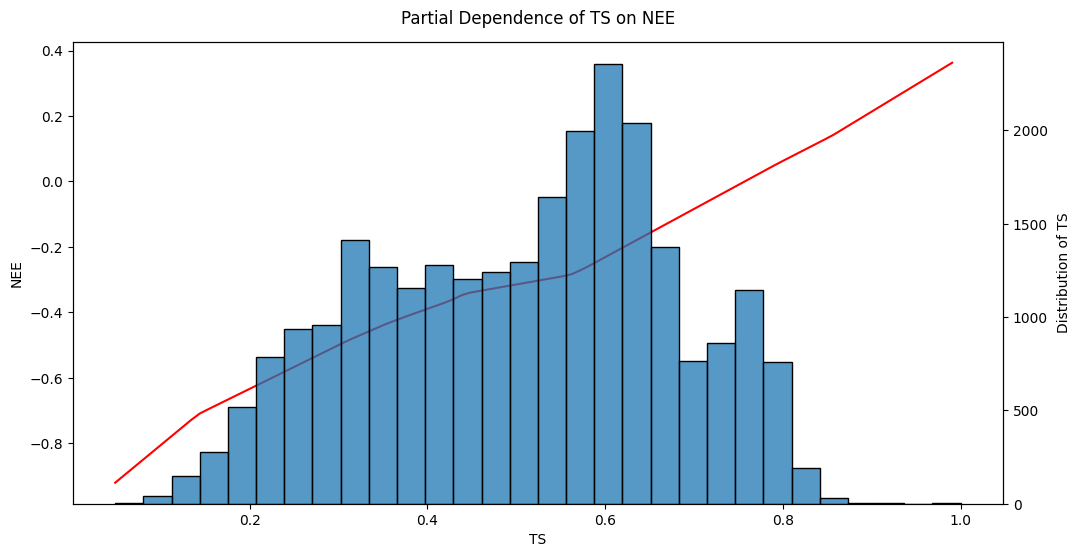

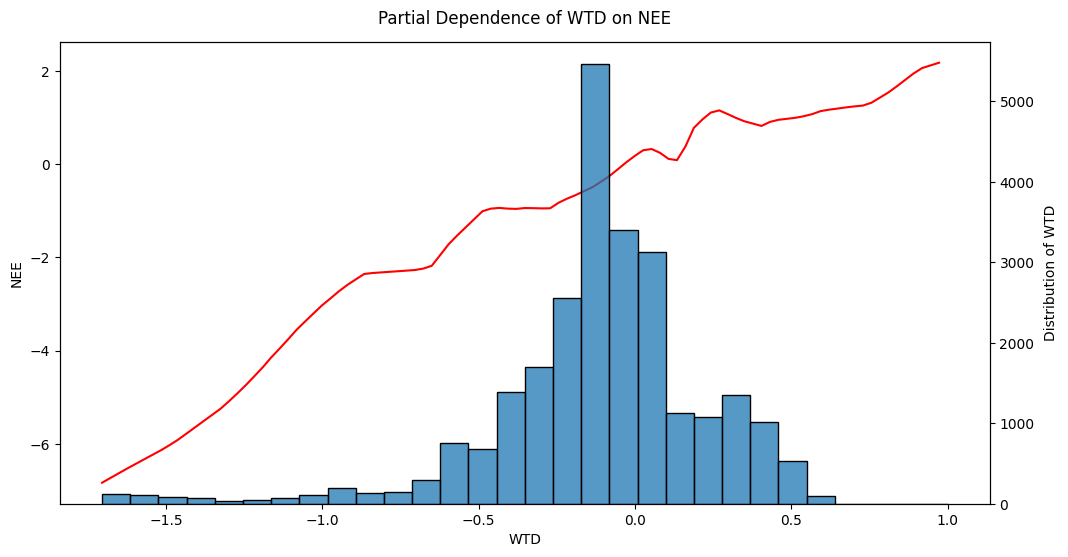

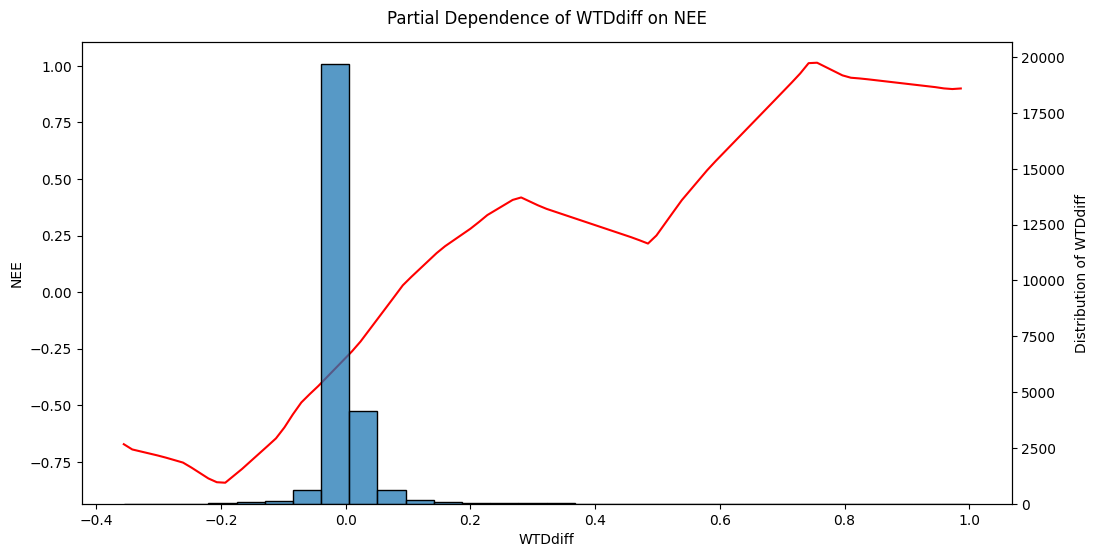

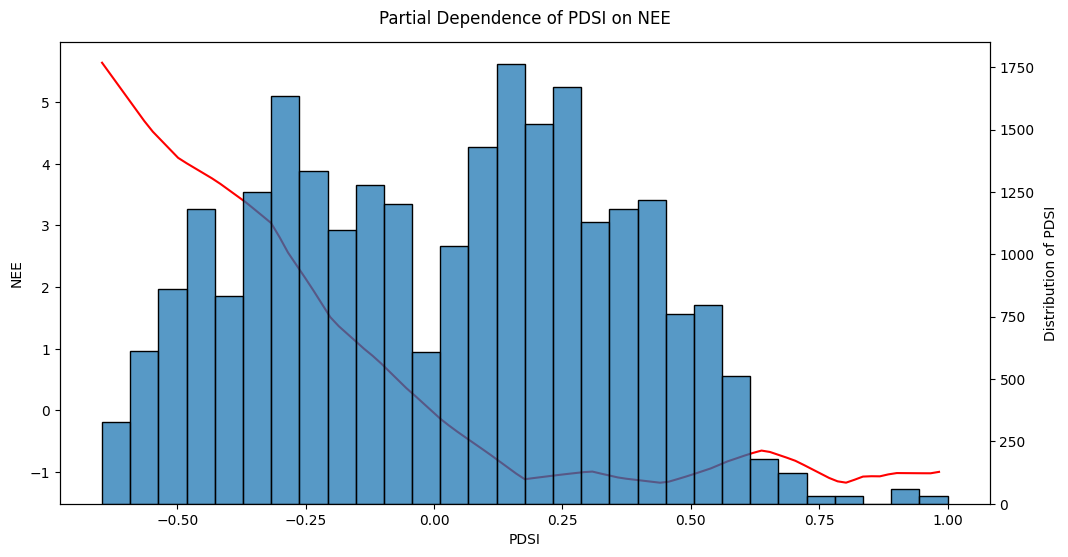

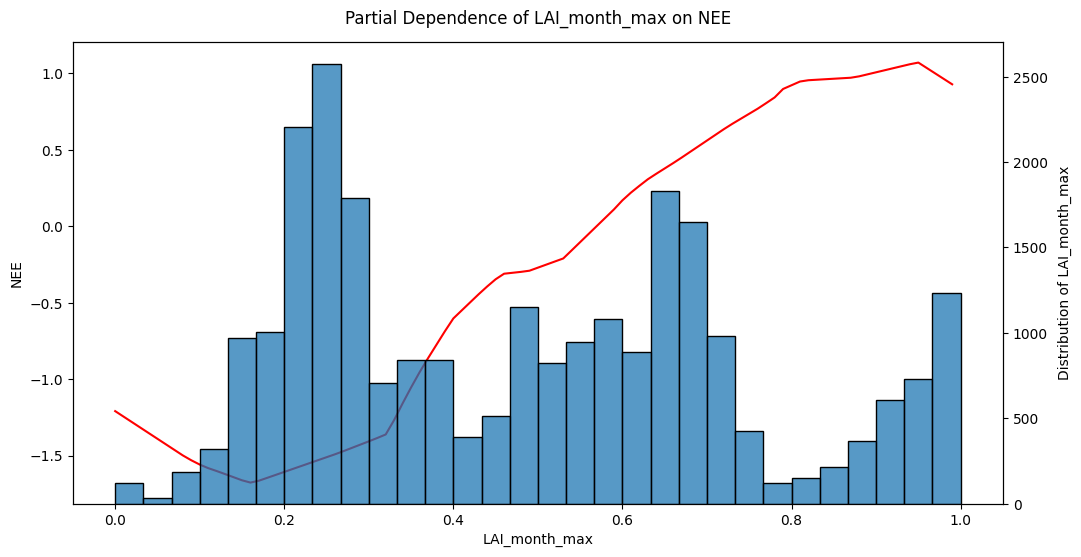

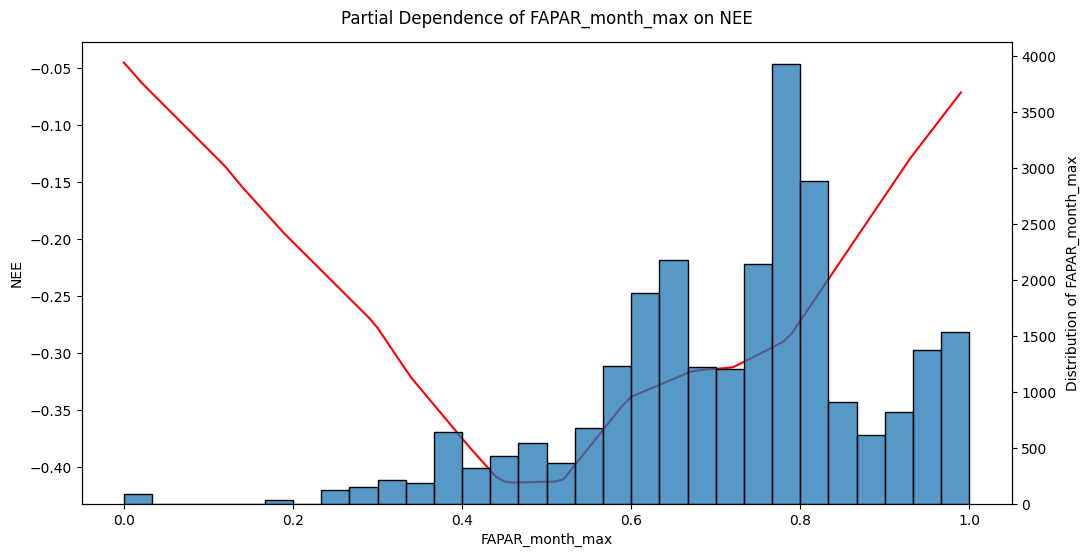

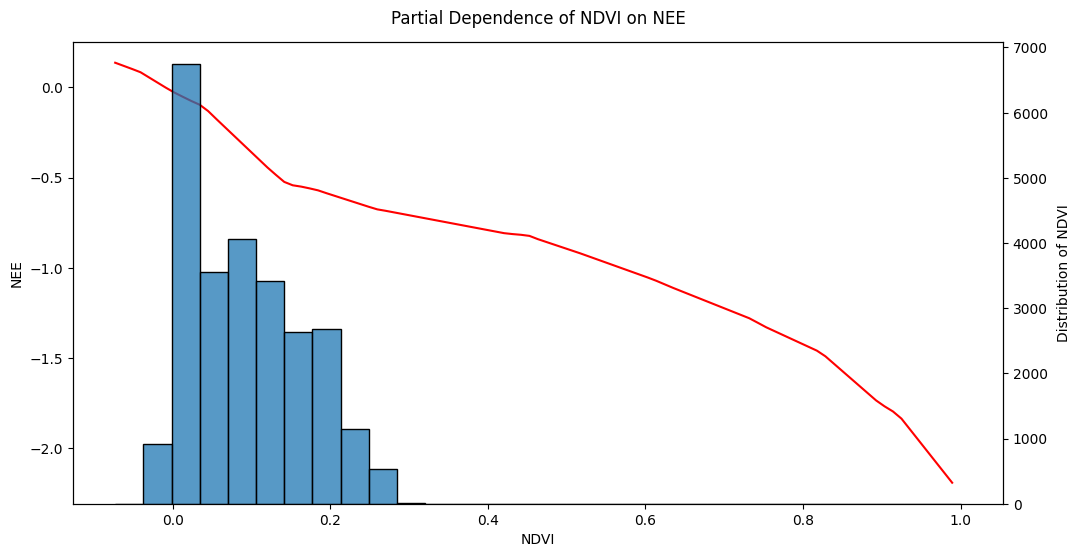

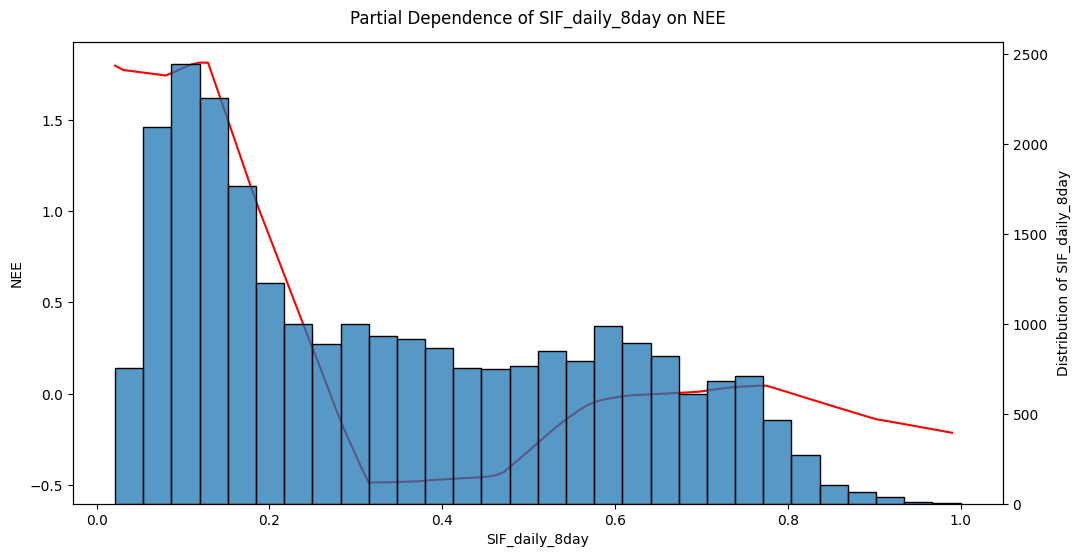

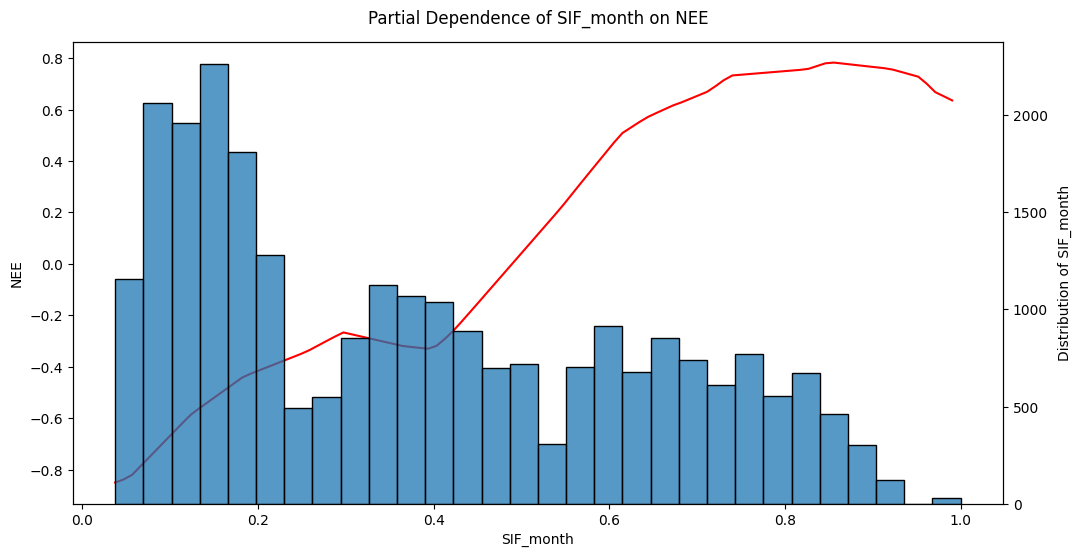

In [15]:
# Create and display multiple plots in a loop
for index in dff.index:
    plt.figure(figsize=(12, 6))  # Create a new figure for each plot
    plt.plot(arg[index], predict_variation[index], color='r')
    plt.xlabel(index)
    plt.ylabel("NEE")
    plt.twinx()
    sns.histplot(df[index], kde=False, bins=30)
    plt.ylabel(f"Distribution of {index}", labelpad=7)
    plt.title(f"Partial Dependence of {index} on NEE", pad=13)